In [1]:
from __init__ import *
from MultiResSolver_ct import *

from skimage.io import imread
from matplotlib import pyplot as plt
import cv2

/home/pourya/.conda/envs/htv_reg/lib/python3.9/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
box_basis = BoxBasis()
rep = 'saved_results/'

In [3]:
img = imread('data/ID_0000_AGE_0060_CONTRAST_1_CT.tif') 
img = (img - np.min(img)) / (img.max() - img.min())
image_size = 255
dim = (image_size, image_size)

# resize image
img = cv2.resize(img, dim, interpolation = cv2.INTER_CUBIC)    
    
device = 'cuda:0'
N_grid = 257
N_theta = 120
N_y = 200
thetas = torch.linspace(0, np.pi, N_theta).to(device).double()
thetas = thetas[:N_theta]
y_values = torch.linspace(-400, 400, N_y)[:, None, None]

c_tensor = F.pad(torch.from_numpy(img), (1, 1, 1, 1))[None, None, :, :].to(device)

x_ray = XrayMS(N_y, N_theta, box_basis, thetas, y_values, device)
x_ray.update_grid(1, N_grid)
y = x_ray.H(c_tensor)

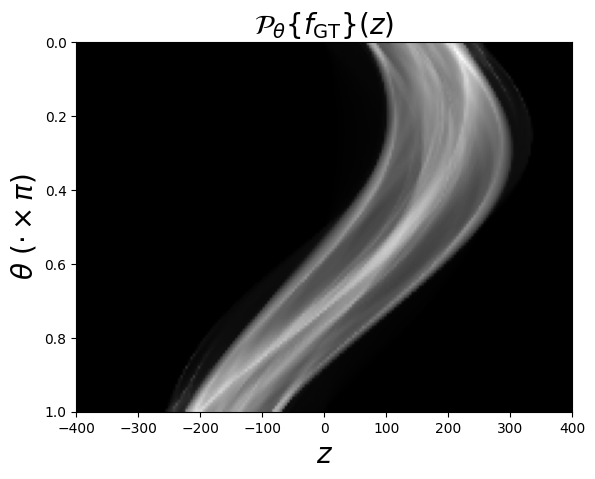

In [4]:
plt.imshow(y.cpu(), cmap='gray', extent=[-400, 400, 1, 0], aspect='auto')
fs = 20
plt.xlabel('$z$', fontsize=fs)
plt.ylabel(r'$\theta$ ($\cdot \times \pi$)', fontsize=fs)
plt.title(r'$\mathcal{P}_{\theta}\{f_{\mathrm{GT}}\}(z)$', fontsize=fs)
plt.show()

In [5]:
sol_0_htv = torch.load(rep + 'mrs_0_htv_0.1.pt')
sol_1_htv = torch.load(rep + 'mrs_1_htv_0.1.pt')
sol_2_htv = torch.load(rep + 'mrs_2_htv_0.1.pt')
sol_3_htv = torch.load(rep + 'mrs_3_htv_0.1.pt')
sol_4_htv = torch.load(rep + 'mrs_4_htv_0.1.pt')

costs_htv = torch.load(rep + 'mrs_htv_cost_0.1.pt')
losses_htv = torch.load(rep + 'mrs_htv_loss_0.1.pt')
regs_htv = torch.load(rep + 'mrs_htv_reg_0.1.pt')
mses_htv = torch.load(rep + 'mrs_htv_mse_0.1.pt')
iters_htv = torch.load(rep + 'mrs_htv_iters_0.1.pt')

In [6]:
sol_0_noreg = torch.load(rep + 'mrs_0_art.pt')
sol_1_noreg = torch.load(rep + 'mrs_1_art.pt')
sol_2_noreg = torch.load(rep + 'mrs_2_art.pt')
sol_3_noreg = torch.load(rep + 'mrs_3_art.pt')
sol_4_noreg = torch.load(rep + 'mrs_4_art.pt')

costs_noreg = torch.load(rep + 'mrs_cost_art.pt')
losses_noreg = torch.load(rep + 'mrs_loss_art.pt')
regs_noreg = torch.load(rep + 'mrs_reg_art.pt')
mses_noreg = torch.load(rep + 'mrs_mse_art.pt')
iters_noreg = torch.load(rep + 'mrs_iters_art.pt')

In [7]:
sol_full = torch.load(rep + 'full_rec.pt').to(device)

In [8]:
psnr_no_reg = np.round(compute_PSNR(sol_4_noreg, Sampler(device).upsample(c_tensor.float()), 1), 1)
psnr_htv = np.round(compute_PSNR(sol_4_htv, Sampler(device).upsample(c_tensor.float()), 1), 1)
psnr_full = np.round(compute_PSNR(Sampler(device).upsample(sol_full.float()), Sampler(device).upsample(c_tensor.float()), 1), 1)

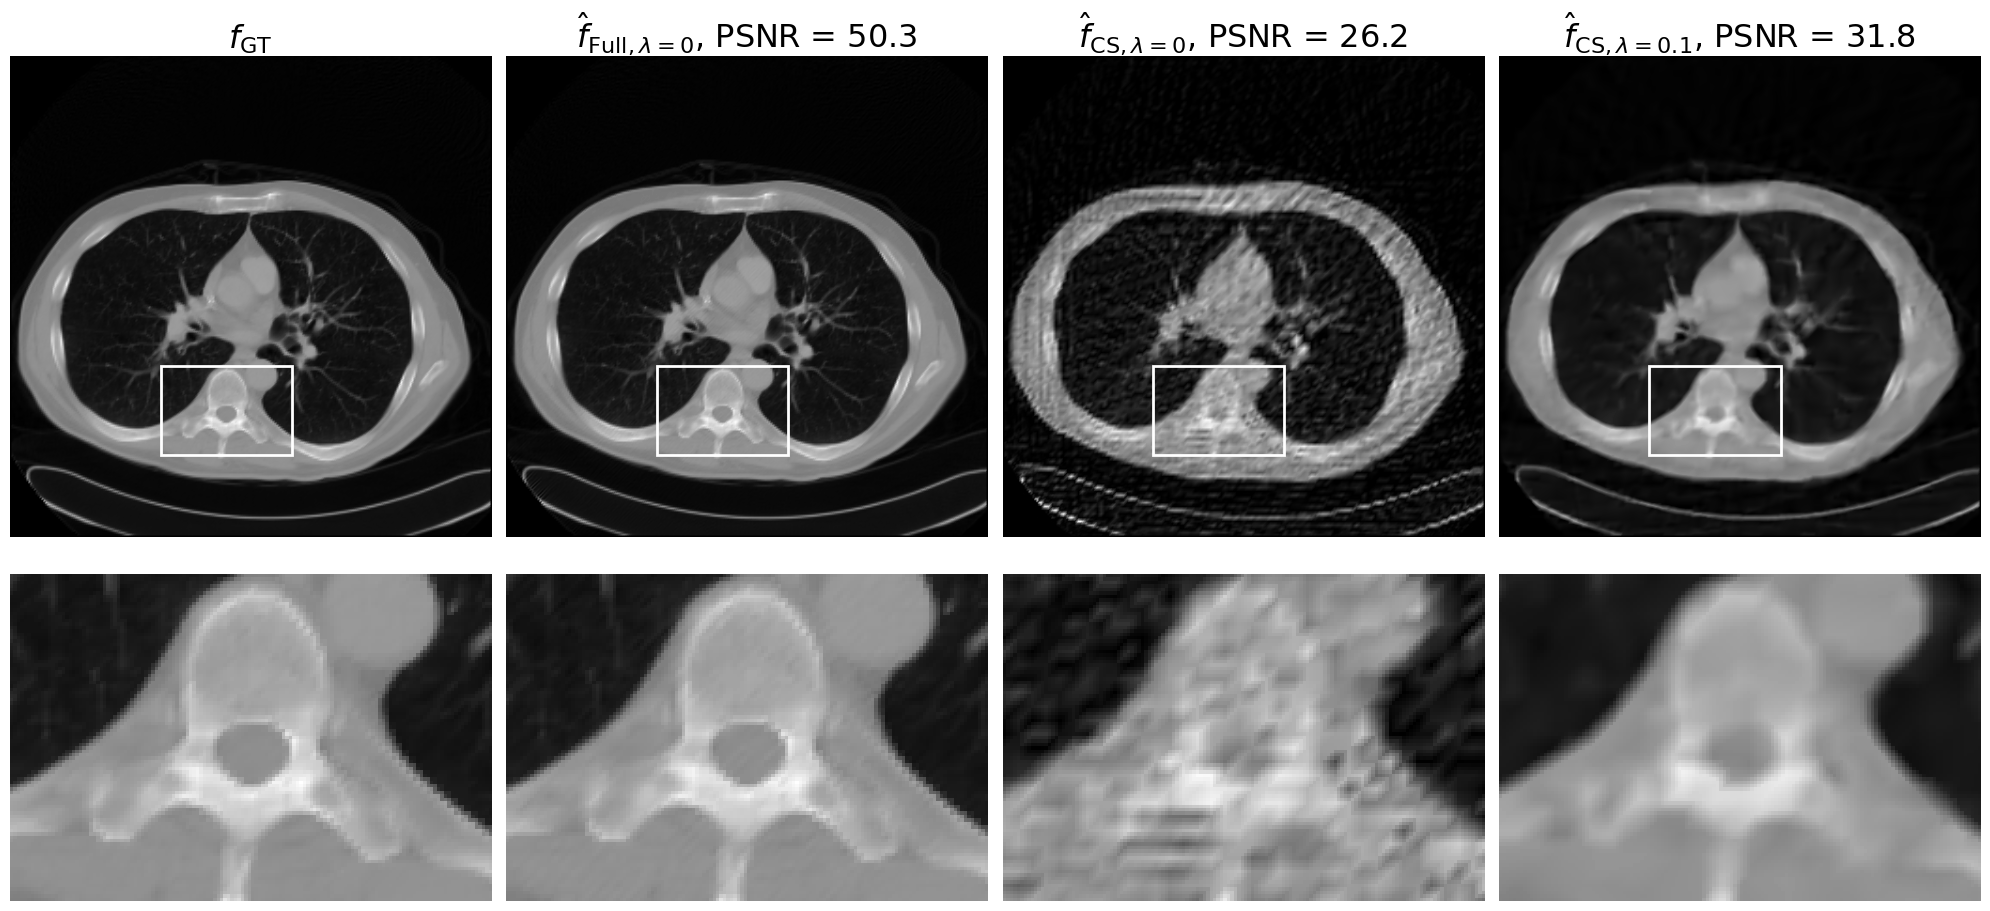

In [9]:
fs = 23
plt.figure(figsize=(20, 10))
plt.subplot(241)
a = 160; b = 330; c1=140; c2=95
gt = Sampler(device).upsample(c_tensor.float())
plt.imshow(gt[0, 0].cpu(), cmap='gray', vmin=0, vmax=1)
rect = patches.Rectangle((a, b), c1, c2, linewidth=2, edgecolor='w', facecolor='none')
ax = plt.gca()
ax.add_patch(rect)
plt.axis('off')
plt.title('$f_{\mathrm{GT}}$', fontsize=fs)
plt.subplot(242)
plt.title('$\hat{f}_{\mathrm{Full}, \lambda = 0}$, PSNR = ' + str(psnr_full), fontsize=fs)
plt.imshow(Sampler(device).upsample(sol_full.float())[0, 0].cpu(), cmap='gray', vmin=0, vmax=1)
rect = patches.Rectangle((a, b), c1, c2, linewidth=2, edgecolor='w', facecolor='none')
ax = plt.gca()
plt.axis('off')
ax.add_patch(rect)
plt.subplot(243)
plt.title('$\hat{f}_{\mathrm{CS}, \lambda = 0}$, PSNR = ' + str(psnr_no_reg), fontsize=fs)
plt.imshow(sol_4_noreg[0, 0].cpu(), cmap='gray', vmin=0, vmax=1)
rect = patches.Rectangle((a, b), c1, c2, linewidth=2, edgecolor='w', facecolor='none')
ax = plt.gca()
plt.axis('off')
ax.add_patch(rect)
plt.subplot(244)
plt.title('$\hat{f}_{\mathrm{CS}, \lambda = 0.1}$, PSNR = ' + str(psnr_htv), fontsize=fs)
plt.imshow(sol_4_htv[0, 0].cpu(), cmap='gray', vmin=0, vmax=1)
rect = patches.Rectangle((a, b), c1, c2, linewidth=2, edgecolor='w', facecolor='none')
ax = plt.gca()
plt.axis('off')
ax.add_patch(rect)
plt.subplot(245)
plt.imshow(gt[0, 0, b:b+c2, a:a+c1].cpu(), cmap='gray', vmin=0, vmax=1)
plt.axis('off')
plt.subplot(246)
plt.imshow(Sampler(device).upsample(sol_full.float())[0, 0, b:b+c2, a:a+c1].cpu(), cmap='gray', vmin=0, vmax=1)
plt.axis('off')
plt.subplot(247)
plt.imshow(sol_4_noreg[0, 0, b:b+c2, a:a+c1].cpu(), cmap='gray', vmin=0, vmax=1)
plt.axis('off')
plt.subplot(248)
plt.imshow(sol_4_htv[0, 0, b:b+c2, a:a+c1].cpu(), cmap='gray', vmin=0, vmax=1)
plt.axis('off')
plt.subplots_adjust(wspace=0, hspace=0.05)
plt.tight_layout()
plt.savefig('saved_figs/compare.png', bbox_inches="tight")
plt.show()

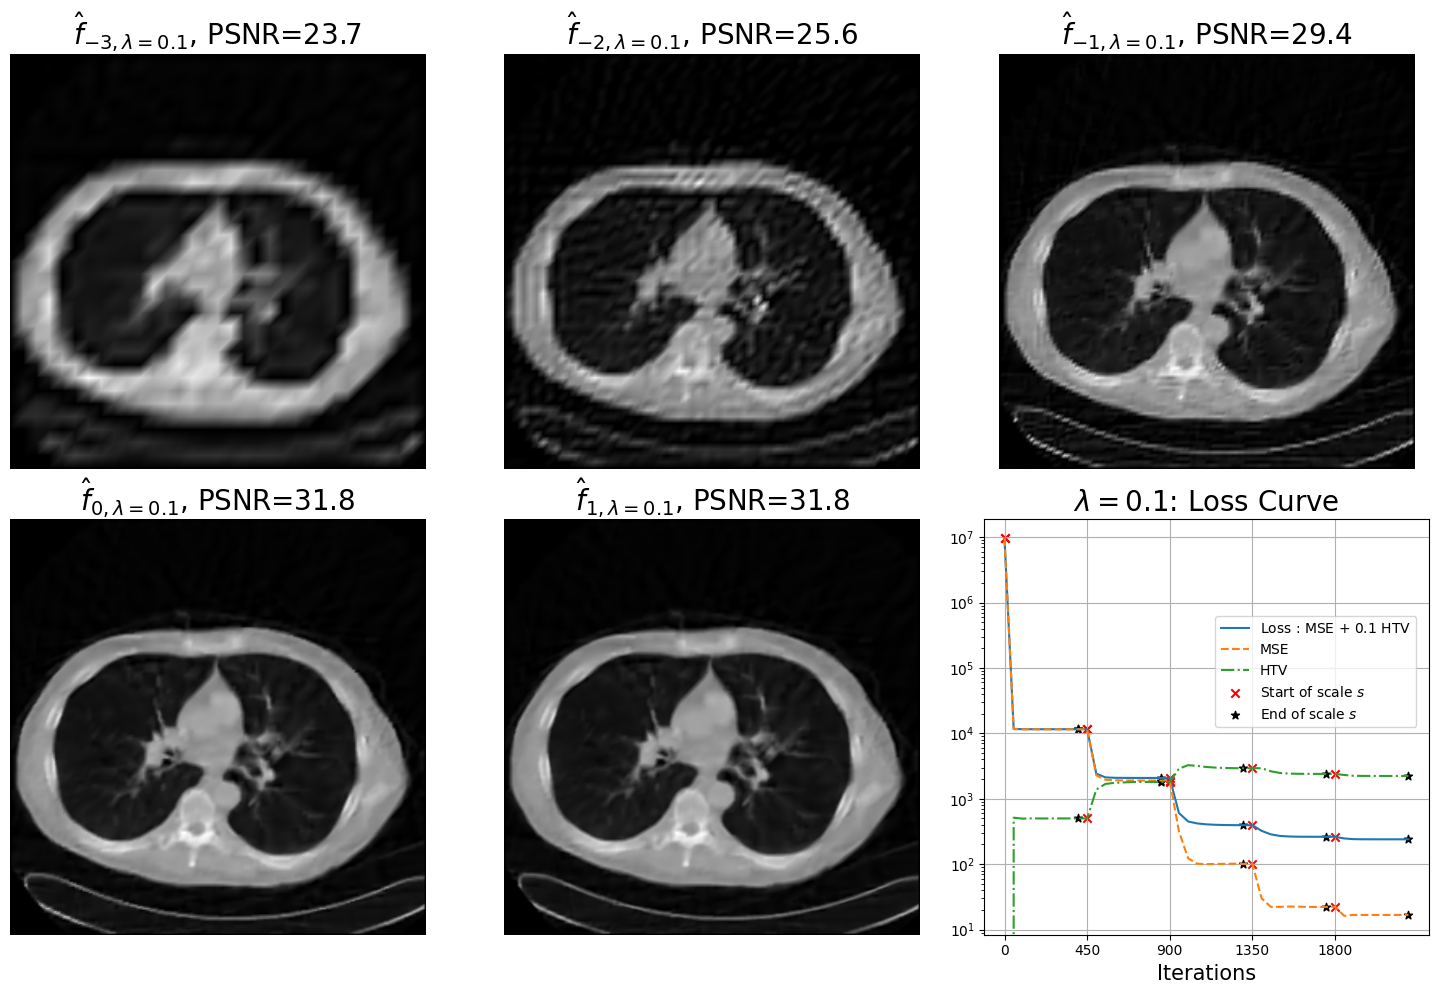

In [10]:
sa = Sampler(device)
fs = 20
plt.figure(figsize=(15, 10))
plt.subplot(231)
plt.imshow(sa.upsample(sa.upsample(sa.upsample(sa.upsample(sol_0_htv.float().to(device)))))[0, 0].cpu(), cmap='gray')
plt.title('$\hat{f}_{-3, \lambda=0.1}$, PSNR=' + str(np.round(compute_PSNR(sa.upsample(c_tensor.float()), sa.upsample(sa.upsample(sa.upsample(sa.upsample(sol_0_htv.float().to(device))))), 1), 1)), fontsize=fs)
plt.axis('off')
plt.subplot(232)
plt.axis('off')
plt.imshow(sa.upsample(sa.upsample(sa.upsample(sol_1_htv.float().to(device))))[0, 0].cpu(), cmap='gray')
plt.title('$\hat{f}_{-2, \lambda=0.1}$, PSNR=' + str(np.round(compute_PSNR(sa.upsample(c_tensor.float()), sa.upsample(sa.upsample(sa.upsample(sol_1_htv.float().to(device)))), 1), 1)), fontsize=fs)
plt.subplot(233)
plt.axis('off')
plt.imshow(sa.upsample(sa.upsample(sol_2_htv.float().to(device)))[0, 0].cpu(), cmap='gray')
plt.title('$\hat{f}_{-1, \lambda=0.1}$, PSNR=' + str(np.round(compute_PSNR(sa.upsample(c_tensor.float()), sa.upsample(sa.upsample(sol_2_htv.float().to(device))), 1), 1)), fontsize=fs)
plt.subplot(234)
plt.axis('off')
plt.imshow(sa.upsample(sol_3_htv.float().to(device))[0, 0].cpu(), cmap='gray')
plt.title('$\hat{f}_{0, \lambda=0.1}$, PSNR=' + str(np.round(compute_PSNR(sa.upsample(c_tensor.float()), sa.upsample(sol_3_htv.float().to(device)), 1), 1)), fontsize=fs)
plt.subplot(235)
plt.axis('off')
plt.imshow(sol_4_htv[0, 0].cpu(), cmap='gray')
plt.title('$\hat{f}_{1, \lambda=0.1}$, PSNR=' + str(np.round(compute_PSNR(sa.upsample(c_tensor.float()), sol_4_htv.float().to(device), 1), 1)), fontsize=fs)
plt.subplot(236)
flat_loss = np.array([item for sublist in losses_htv for item in sublist])
flat_mse = np.array([item for sublist in mses_htv for item in sublist])
flat_reg = np.array([item for sublist in regs_htv  for item in sublist])
scale_change = [0, 9, 18, 27, 36]
scale_change_p = [0, 9*50, 18*50, 27*50, 36*50]
plt.plot([i * 50 for i in range(len(flat_loss))], flat_loss, label='Loss : MSE + $0.1$ HTV')
plt.plot([i * 50 for i in range(len(flat_loss))], flat_mse, label='MSE', linestyle='dashed')
plt.plot([i * 50 for i in range(len(flat_loss))], flat_reg, label='HTV', linestyle='-.')
plt.yscale('log')
ax = plt.gca()
plt.grid('on')
ax.set_xticks([i * 450 for i in range(5)])
plt.scatter(scale_change_p, flat_loss[scale_change], c='red', marker='x', label='Start of scale $s$')
plt.scatter(scale_change_p, flat_mse[scale_change], c='red', marker='x')
plt.scatter(scale_change_p, flat_reg[scale_change], c='red', marker='x')
scale_change = [8, 17, 26, 35, 44]
scale_change_p = [8*50, 17*50, 26*50, 35*50, 44*50]
plt.scatter(scale_change_p, flat_loss[scale_change], c='black', marker='*', label='End of scale $s$')
plt.scatter(scale_change_p, flat_mse[scale_change], c='black', marker='*')
plt.scatter(scale_change_p, flat_reg[scale_change], c='black', marker='*')
plt.legend(loc=(0.52, 0.5))
plt.xlabel('Iterations', fontsize=fs*3/4)
plt.title('$\lambda=0.1$: Loss Curve', fontsize=fs)
plt.tight_layout()
plt.show()

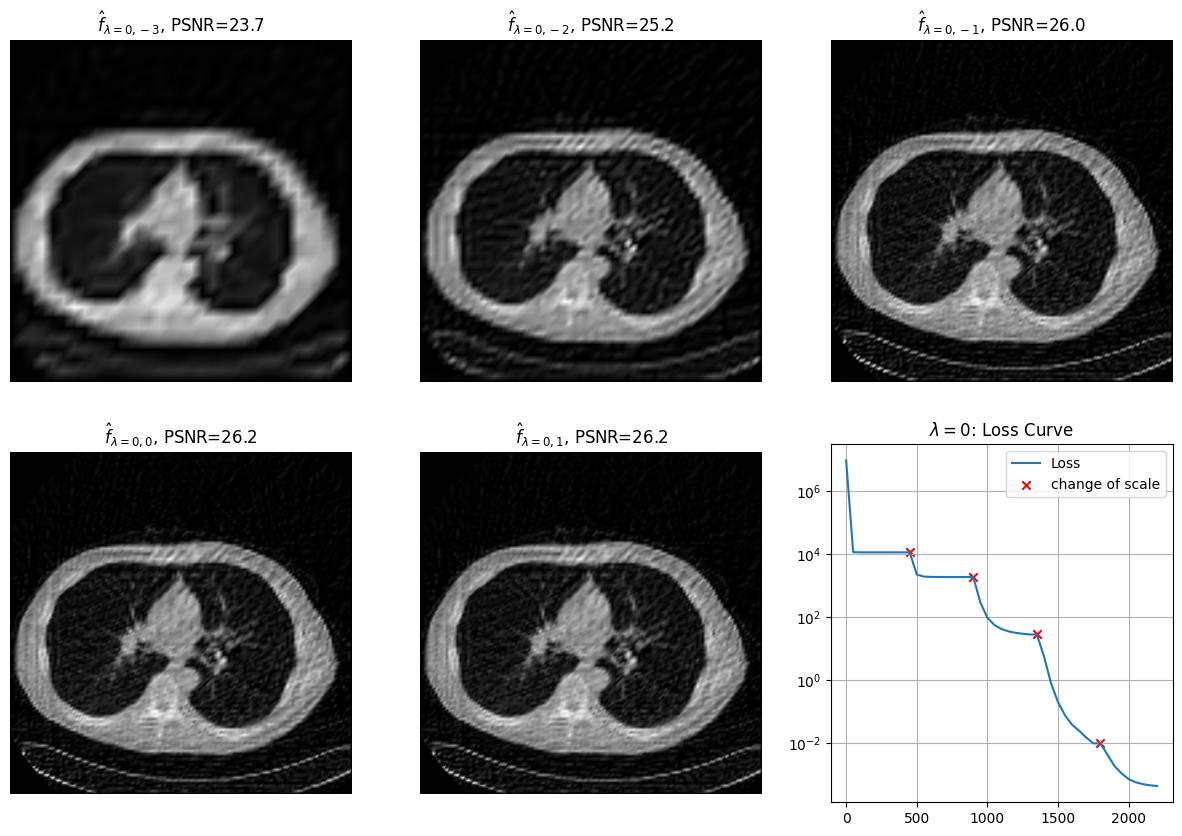

In [11]:
sa = Sampler(device)
plt.figure(figsize=(15, 10))
plt.subplot(231)
plt.axis('off')
plt.imshow(sa.upsample(sa.upsample(sa.upsample(sa.upsample(sol_0_noreg.float().to(device)))))[0, 0].cpu(), cmap='gray')
plt.title('$\hat{f}_{\lambda=0, -3}$, PSNR=' + str(np.round(compute_PSNR(sa.upsample(c_tensor.float()), sa.upsample(sa.upsample(sa.upsample(sa.upsample(sol_0_noreg.float().to(device))))), 1), 1)))
plt.subplot(232)
plt.axis('off')
plt.imshow(sa.upsample(sa.upsample(sa.upsample(sol_1_noreg.float().to(device))))[0, 0].cpu(), cmap='gray')
plt.title('$\hat{f}_{\lambda=0, -2}$, PSNR=' + str(np.round(compute_PSNR(sa.upsample(c_tensor.float()), sa.upsample(sa.upsample(sa.upsample(sol_1_noreg.float().to(device)))), 1), 1)))
plt.subplot(233)
plt.axis('off')
plt.imshow(sa.upsample(sa.upsample(sol_2_noreg.float().to(device)))[0, 0].cpu(), cmap='gray')
plt.title('$\hat{f}_{\lambda=0, -1}$, PSNR=' + str(np.round(compute_PSNR(sa.upsample(c_tensor.float()), sa.upsample(sa.upsample(sol_2_noreg.float().to(device))), 1), 1)))
plt.subplot(234)
plt.axis('off')
plt.imshow(sa.upsample(sol_3_noreg.float().to(device))[0, 0].cpu(), cmap='gray')
plt.title('$\hat{f}_{\lambda=0, 0}$, PSNR=' + str(np.round(compute_PSNR(sa.upsample(c_tensor.float()), sa.upsample(sol_3_noreg.float().to(device)), 1), 1)))
plt.subplot(235)
plt.axis('off')
plt.imshow(sol_4_noreg[0, 0].cpu(), cmap='gray')
plt.title('$\hat{f}_{\lambda=0, 1}$, PSNR=' + str(np.round(compute_PSNR(sa.upsample(c_tensor.float()), sol_4_noreg.float().to(device), 1), 1)))
plt.subplot(236)
flat_loss = np.array([item for sublist in losses_noreg for item in sublist])
scale_change = [9, 18, 27, 36]
scale_change_p = [9*50, 18*50, 27*50, 36*50]
plt.plot([i * 50 for i in range(len(flat_loss))], flat_loss, label='Loss')
plt.yscale('log')
plt.grid('on')
plt.scatter(scale_change_p, flat_loss[scale_change], c='red', marker='x', label='change of scale')
plt.legend()
plt.title('$\lambda = 0$: Loss Curve')
plt.subplots_adjust(wspace=0.2, hspace=0.15)
plt.show()

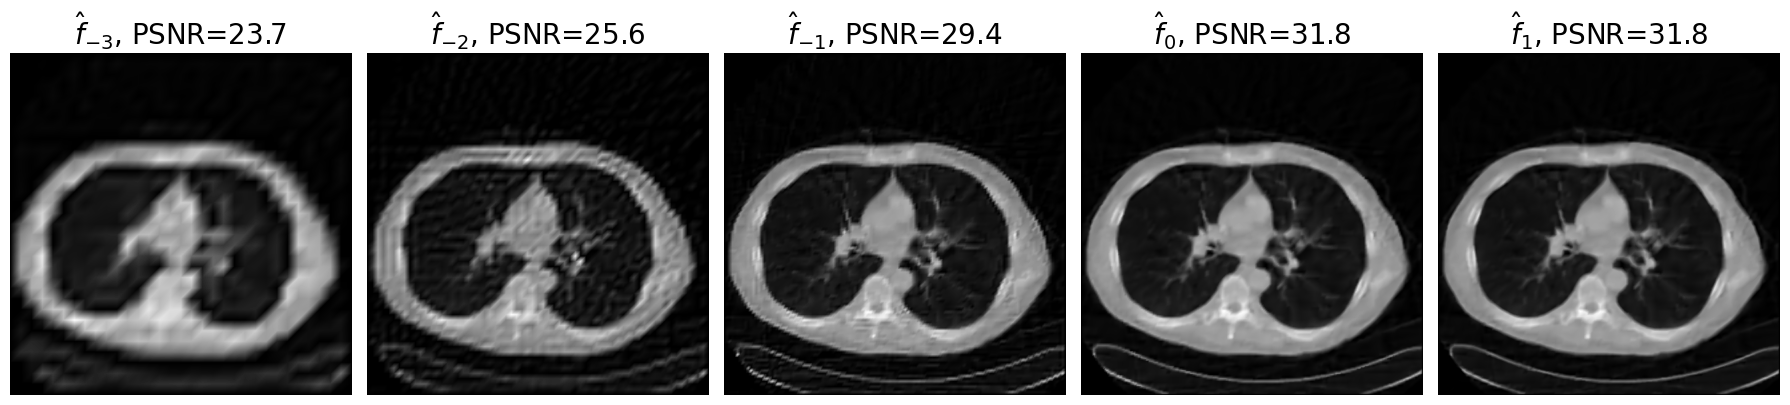

In [12]:
sa = Sampler(device)
fs = 20
plt.figure(figsize=(18, 6))
plt.subplot(151)
plt.imshow(sa.upsample(sa.upsample(sa.upsample(sa.upsample(sol_0_htv.float().to(device)))))[0, 0].cpu(), cmap='gray')
plt.title('$\hat{f}_{-3}$, PSNR=' + str(np.round(compute_PSNR(sa.upsample(c_tensor.float()), sa.upsample(sa.upsample(sa.upsample(sa.upsample(sol_0_htv.float().to(device))))), 1), 1)), fontsize=fs)
plt.axis('off')
plt.subplot(152)
plt.axis('off')
plt.imshow(sa.upsample(sa.upsample(sa.upsample(sol_1_htv.float().to(device))))[0, 0].cpu(), cmap='gray')
plt.title('$\hat{f}_{-2}$, PSNR=' + str(np.round(compute_PSNR(sa.upsample(c_tensor.float()), sa.upsample(sa.upsample(sa.upsample(sol_1_htv.float().to(device)))), 1), 1)), fontsize=fs)
plt.subplot(153)
plt.axis('off')
plt.imshow(sa.upsample(sa.upsample(sol_2_htv.float().to(device)))[0, 0].cpu(), cmap='gray')
plt.title('$\hat{f}_{-1}$, PSNR=' + str(np.round(compute_PSNR(sa.upsample(c_tensor.float()), sa.upsample(sa.upsample(sol_2_htv.float().to(device))), 1), 1)), fontsize=fs)
plt.subplot(154)
plt.axis('off')
plt.imshow(sa.upsample(sol_3_htv.float().to(device))[0, 0].cpu(), cmap='gray')
plt.title('$\hat{f}_{0}$, PSNR=' + str(np.round(compute_PSNR(sa.upsample(c_tensor.float()), sa.upsample(sol_3_htv.float().to(device)), 1), 1)), fontsize=fs)
plt.subplot(155)
plt.axis('off')
plt.imshow(sol_4_htv[0, 0].cpu(), cmap='gray')
plt.title('$\hat{f}_{1}$, PSNR=' + str(np.round(compute_PSNR(sa.upsample(c_tensor.float()), sol_4_htv.float().to(device), 1), 1)), fontsize=fs)
plt.tight_layout()
plt.savefig('saved_figs/multires_htv.png', bbox_inches="tight")

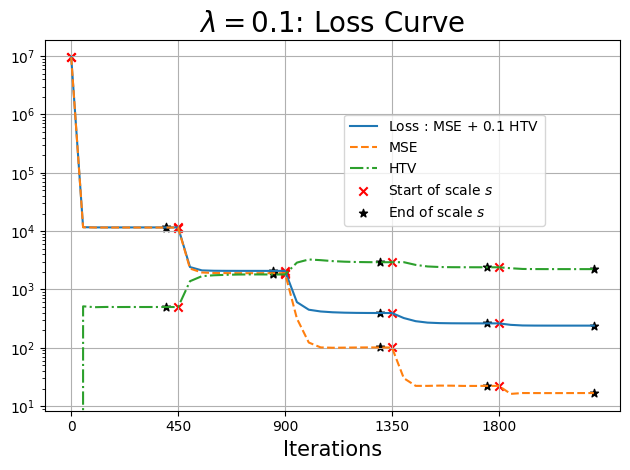

In [13]:
flat_loss = np.array([item for sublist in losses_htv for item in sublist])
flat_mse = np.array([item for sublist in mses_htv for item in sublist])
flat_reg = np.array([item for sublist in regs_htv  for item in sublist])
scale_change = [0, 9, 18, 27, 36]
scale_change_p = [0, 9*50, 18*50, 27*50, 36*50]
plt.plot([i * 50 for i in range(len(flat_loss))], flat_loss, label='Loss : MSE + $0.1$ HTV')
plt.plot([i * 50 for i in range(len(flat_loss))], flat_mse, label='MSE', linestyle='dashed')
plt.plot([i * 50 for i in range(len(flat_loss))], flat_reg, label='HTV', linestyle='-.')
plt.yscale('log')
ax = plt.gca()
plt.grid('on')
ax.set_xticks([i * 450 for i in range(5)])
plt.scatter(scale_change_p, flat_loss[scale_change], c='red', marker='x', label='Start of scale $s$')
plt.scatter(scale_change_p, flat_mse[scale_change], c='red', marker='x')
plt.scatter(scale_change_p, flat_reg[scale_change], c='red', marker='x')
scale_change = [8, 17, 26, 35, 44]
scale_change_p = [8*50, 17*50, 26*50, 35*50, 44*50]
plt.scatter(scale_change_p, flat_loss[scale_change], c='black', marker='*', label='End of scale $s$')
plt.scatter(scale_change_p, flat_mse[scale_change], c='black', marker='*')
plt.scatter(scale_change_p, flat_reg[scale_change], c='black', marker='*')
plt.legend(loc=(0.52, 0.5))
plt.xlabel('Iterations', fontsize=fs*3/4)
plt.title('$\lambda=0.1$: Loss Curve', fontsize=fs)
plt.tight_layout()
plt.savefig('saved_figs/loss_curve.png', bbox_inches="tight")
plt.show()